In [161]:
import torch 
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from train import train
from torch.optim import Adam
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [162]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Ammount of objects already turned to categorical format, so:
0 -  means no objects 
1 - means 1-5 objects (few)
2 - means 6-10 (some)
3 - means >10 objects (a lot)

Ammount of avalailable weapons means:
0 - no amunition of this type (0)
1 - a few amunition of this type (<10)
2 - some amunition of this type (10-50)
3 - enought amunition of this type (<50)

All of above ammounts could be changed so for example 1 as a detectes combat vehicle could mean not 1-5 but 1-3 detected objects. It will be realized in following code part.


Descisions are also turned into categorical format:
0 - means to use anti-tank guided missile (atgm)
1 - means to use clusster shells 
2 - means to use unitae shells 
3 - means to use FPV kamikaze-drones
4 - means to use troop guns
5 - means to use anti-tank guided missile (atgm) and troop guns in same time 
6 - means to use troop guns and FPV kamikaze-drones
7 - means to use rest of ammunition 


In [163]:
data = pd.read_csv("/Users/maxkucher/shelling /vehicles.csv", index_col=False)
data = data.drop("Unnamed: 0", axis='columns')
data

,tanks_ammount,ifv_ammount,apc_ammount,atgm_ammount,clusster_shells_ammount,unitar_shells_ammount,fpv_ammount,descision
0,0,0,1,0,0,0,0,4.0
1,0,0,1,0,0,0,1,3.0
2,0,0,1,0,0,0,2,3.0
3,0,0,1,0,0,0,3,3.0
4,0,0,1,0,0,1,0,2.0
...,...,...,...,...,...,...,...,...
16122,3,3,3,3,3,2,2,0.0
16123,3,3,3,3,3,2,3,0.0
16124,3,3,3,3,3,3,0,0.0
16125,3,3,3,3,3,3,1,0.0


In [164]:
x = data.drop("descision", axis="columns")
y = data["descision"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

In [165]:
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.FloatTensor(x.values)
        self.y = torch.LongTensor(y.values)
        # self.y = self.y.reshape(-1, 1)
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [166]:
train_dataset = MyDataset(x_train, y_train)
test_dataset = MyDataset(x_test, y_test)

In [167]:
len(train_dataset), len(test_dataset)

(12901, 3226)

In [168]:
x_train.shape

(12901, 7)

In [169]:
y_train.value_counts()

descision
0.0    9675
2.0    2229
5.0     418
3.0     378
1.0     151
4.0      50
Name: count, dtype: int64

In [170]:
train_dataset[3]

(tensor([1., 3., 3., 2., 0., 2., 0.]), tensor(0))

In [171]:
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=device))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=device))


In [172]:
class VehiclesModel(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()

        self.linear1 = nn.Linear(in_features=7, out_features=28)
        self.bnorm1 = nn.BatchNorm1d(28)
        self.linear2 = nn.Linear(in_features=28, out_features=24)
        self.drop1 = nn.Dropout(0.3)
        self.linear3 = nn.Linear(in_features=24, out_features=16)
        self.linear4 = nn.Linear(in_features=16, out_features=8)
        self.linear5 = nn.Linear(in_features=8, out_features=num_classes)

    def forward(self, x):
        out = self.linear1(x)
        out = F.relu(out)
        out = self.bnorm1(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.drop1(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        out = F.relu(out)
        out = self.linear5(out)
        return out
    
    def predict(self, x):
        x = torch.FloatTensor(x).to(device)
        with torch.no_grad():
            y_pred = F.softmax(self.forward(x), dim=-1)

        return y_pred
    
model = VehiclesModel().to(device)
model

VehiclesModel(
  (linear1): Linear(in_features=7, out_features=28, bias=True)
  (bnorm1): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=28, out_features=24, bias=True)
  (drop1): Dropout(p=0.3, inplace=False)
  (linear3): Linear(in_features=24, out_features=16, bias=True)
  (linear4): Linear(in_features=16, out_features=8, bias=True)
  (linear5): Linear(in_features=8, out_features=6, bias=True)
)

In [173]:
%pip install -q torchsummary

You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [174]:
from torchsummary import summary

summary(model, input_size=(7, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 28]             224
       BatchNorm1d-2                   [-1, 28]              56
            Linear-3                   [-1, 24]             696
           Dropout-4                   [-1, 24]               0
            Linear-5                   [-1, 16]             400
            Linear-6                    [-1, 8]             136
            Linear-7                    [-1, 6]              54
Total params: 1,566
Trainable params: 1,566
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [175]:
loss_func = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)

In [176]:
history = train(model, optimizer, loss_func, train_dataloader, test_dataloader, epochs=50, metrics=[accuracy_score], 
                device=device, task="multiclass")

Epoch    1    1sec	loss:      0.537	val_loss:      0.201	accuracy_score:      0.803	val_accuracy_score:      0.923	
Epoch    2    1sec	loss:      0.191	val_loss:      0.183	accuracy_score:      0.922	val_accuracy_score:      0.923	
Epoch    3    1sec	loss:      0.162	val_loss:       0.15	accuracy_score:      0.923	val_accuracy_score:      0.933	
Epoch    4    1sec	loss:      0.138	val_loss:      0.128	accuracy_score:      0.945	val_accuracy_score:      0.955	
Epoch    5    1sec	loss:      0.115	val_loss:      0.113	accuracy_score:      0.963	val_accuracy_score:      0.975	
Epoch    6    1sec	loss:      0.103	val_loss:      0.106	accuracy_score:      0.969	val_accuracy_score:      0.974	
Epoch    7    1sec	loss:      0.091	val_loss:     0.0807	accuracy_score:      0.972	val_accuracy_score:      0.977	
Epoch    8    1sec	loss:     0.0871	val_loss:     0.0916	accuracy_score:      0.972	val_accuracy_score:      0.975	
Epoch    9    1sec	loss:     0.0807	val_loss:     0.0632	accuracy_score:

In [177]:
# Пример данных (замените на свои)


# Преобразование данных в тензор
# x_test_tensor = torch.FloatTensor(x_test)


loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset))
X_test, y_test = next(iter(loader))

# Вызов метода predict
y_pred = model.predict(X_test)

# Получение предсказанных классов (если это задача классификации)
predicted_classes = torch.argmax(y_pred, dim=1).cpu().numpy()

print(predicted_classes)


[0 0 5 ... 2 0 2]


In [178]:
len(y_test)

3226

[]

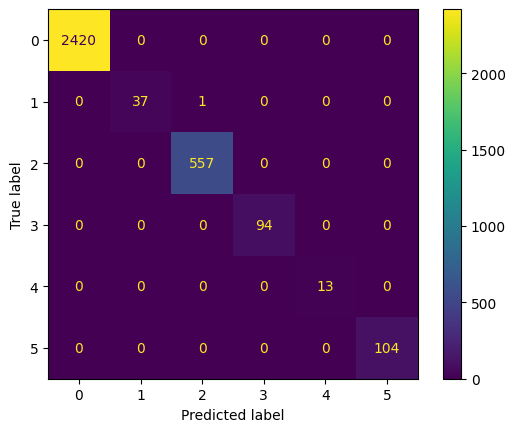

In [179]:
ConfusionMatrixDisplay.from_predictions(y_test, predicted_classes)
plt.plot()

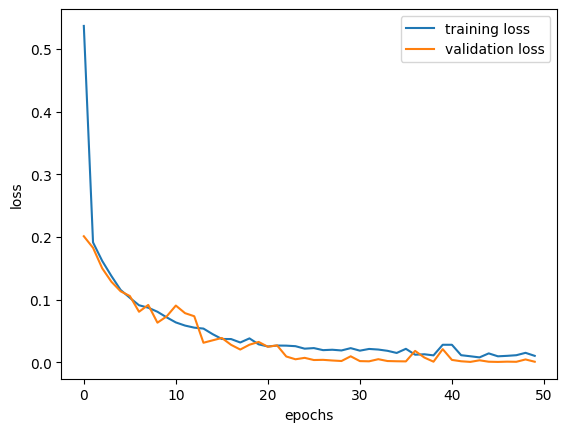

In [180]:
plt.plot(history["loss"], label="training loss")
plt.plot(history["val_loss"], label="validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [181]:
import torch

commands = ["ATGM", "Clusster shells", "Unitar shells", "FPV-drones", "Machine gun", "ATGM/Guns", "FPV/Guns", "Rest of amunition"]

x = torch.FloatTensor([0, 0, 1, 0, 0, 0, 0]).to(device)
x = x.unsqueeze(0)
model.eval()

with torch.no_grad():
    res = model(x)

t_x = torch.argmax(res)
t_array = np.array(t_x)


print(commands[t_array])


Machine gun


In [184]:
torch.save(model, "vehicles.pt")

In [188]:
torch.save(model.state_dict(), "vehicles.pt")